# Распознавание лиц при помощи SVM и kernel trick

# Описание набора данных

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет.

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [ ]:
df = pd.read_csv('persons_pics_train.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell


Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения.

In [ ]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

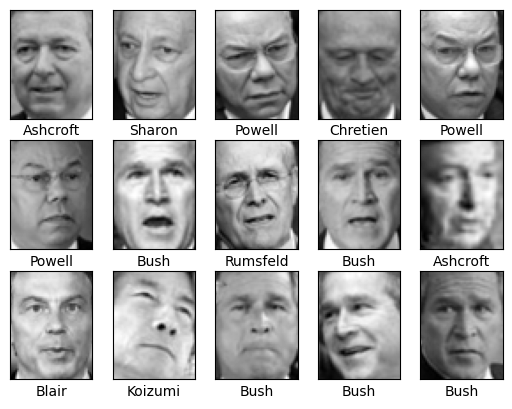

In [ ]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')

Крупнее

(-0.5, 46.5, 61.5, -0.5)

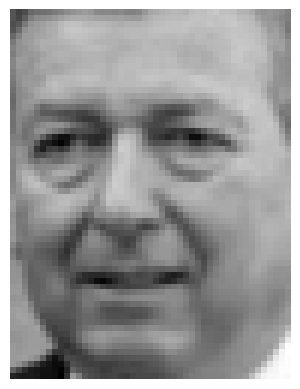

In [ ]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

In [ ]:
df.shape

(1326, 2915)

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных.

In [ ]:
df["label"].nunique()

12

Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса.

In [ ]:
count_jacques_chirac = df[df["label"] == "Jacques Chirac"].shape[0]

# Подсчитайте общее количество объектов в датасете
total_objects = df.shape[0]

# Вычислите долю объектов класса "Jacques Chirac"
fraction_jacques_chirac = count_jacques_chirac / total_objects

print("Доля объектов класса Jacques Chirac:", fraction_jacques_chirac)

Доля объектов класса Jacques Chirac: 0.033182503770739065


На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком.

In [ ]:
grouped_data = df.groupby("label")

# Создание словаря, в котором ключами будут имена, а значениями средние векторы
mean_vectors = {}

# Перебор групп и вычисление средних векторов
for name, group in grouped_data:
    mean_vector = group.iloc[:, :-1].mean()  # Вычисление среднего вектора (исключая последний столбец с метками)
    mean_vectors[name] = mean_vector

Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания.

In [ ]:
# Замените "Gerhard Schroeder" на имя человека, для которого вам нужна координата
target_name = "Gerhard Schroeder"

# Получите средний вектор для целевого человека
mean_vector_target = mean_vectors.get(target_name)

# Задайте индекс i, который вам интересен (например, i = 0 для первой координаты)
i = 0

# Получите значение координаты с индексом i
coordinate_value = mean_vector_target[i]

print("Координата с индексом", i, "для", target_name, ":", coordinate_value)

Координата с индексом 0 для Gerhard Schroeder : 0.21016234977419354


Используя усредненные векторы, постройте изображения всех людей из набора данных.

IndexError: ignored

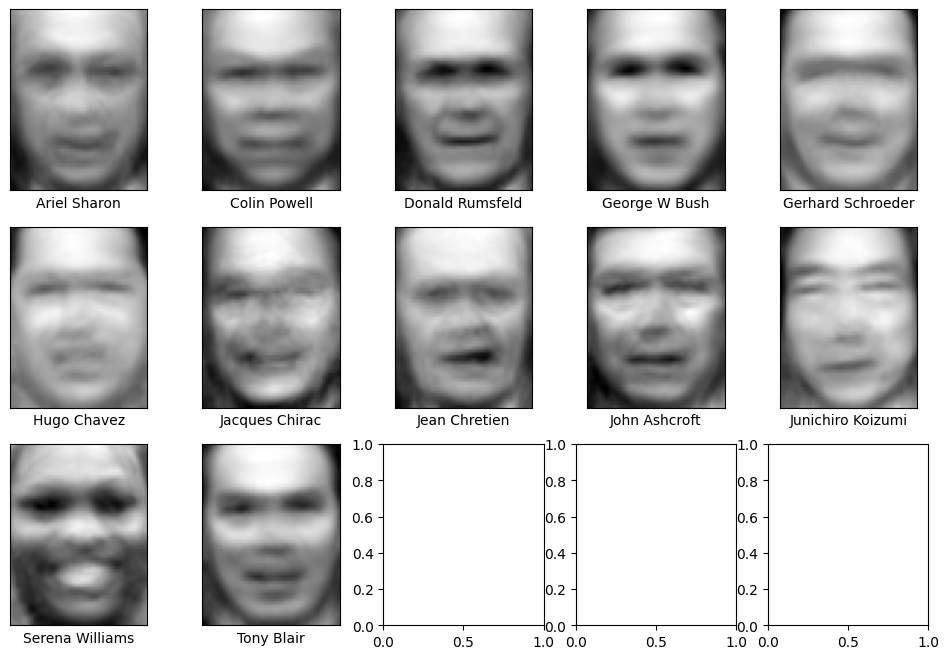

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Загрузите данные
df = pd.read_csv('persons_pics_train.csv')

# Создание словаря, в котором ключами будут имена, а значениями средние векторы
mean_vectors = {}

# Перебор групп и вычисление средних векторов
for name, group in df.groupby("label"):
    mean_vector = group.iloc[:, :-1].mean()  # Вычисление среднего вектора (исключая последний столбец с метками)
    mean_vectors[name] = mean_vector

# Создайте графическое представление всех усредненных векторов
fig, ax = plt.subplots(3, 5, figsize=(12, 8))
for i, axi in enumerate(ax.flat):
    person_name = list(mean_vectors.keys())[i]
    mean_vector = mean_vectors[person_name]
    image = mean_vector.values.reshape(62, 47)
    axi.imshow(image, cmap='gray')
    axi.set(xticks=[], yticks=[], xlabel=person_name)

plt.tight_layout()
plt.show()

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

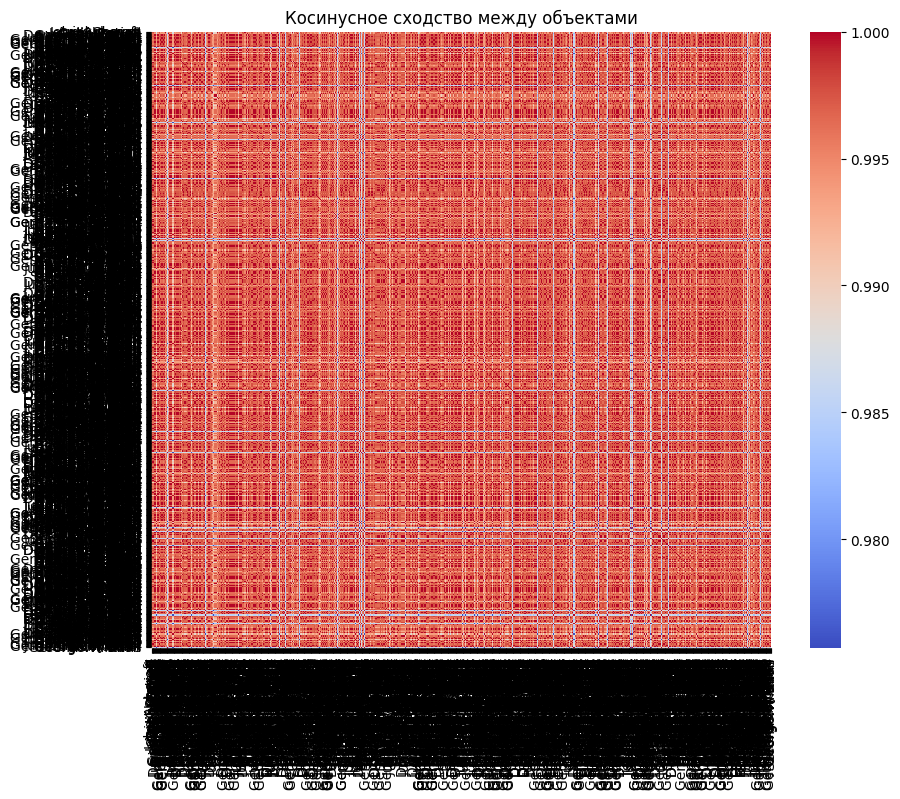

Косинусное сходство между Donald Rumsfeld и Serena Williams: 0.9866


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Создание матрицы сходства на основе усредненных векторов
similarity_matrix = cosine_similarity([mean_vectors[name] for name in df['label']])

# Визуализация матрицы сходства в виде тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=False, cmap='coolwarm', xticklabels=df['label'], yticklabels=df['label'])
plt.title("Косинусное сходство между объектами")
plt.show()

# Найдем косинусное сходство между Donald Rumsfeld и Serena Williams
person1 = "Donald Rumsfeld"
person2 = "Serena Williams"

index1 = df[df["label"] == person1].index[0]
index2 = df[df["label"] == person2].index[0]

similarity_value = similarity_matrix[index1, index2]
print(f"Косинусное сходство между {person1} и {person2}: {similarity_value:.4f}")

In [ ]:
print(f"Косинусное сходство между {person1} и {person2}: {similarity_value:.3f}")

Косинусное сходство между Donald Rumsfeld и Serena Williams: 0.987


Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов.

In [ ]:
# < ENTER YOUR CODE HERE >

# Построение модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# Разделение данных на обучающую и тестовую выборки с учетом стратификации
X = df.drop(columns=['label'])  # Признаки
y = df['label']  # Метки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

# Обучение модели SVC с указанными параметрами
model = SVC(kernel='linear', random_state=5)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Вычисление f1_score на тестовых данных с усреднением 'weighted'
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("F1 Score (average='weighted') на тестовых данных:", f1_weighted)

F1 Score (average='weighted') на тестовых данных: 0.7408103886614767


## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [ ]:
# < ENTER YOUR CODE HERE >

Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [ ]:
# < ENTER YOUR CODE HERE >

В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [ ]:
from sklearn.model_selection import GridSearchCV

# Определите набор параметров для поиска
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                     'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000],
                     'class_weight': [None, 'balanced'],
                     'random_state': [5]}]

# Создайте объект GridSearchCV
cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

# Обучите модели с различными комбинациями параметров
cv.fit(X_train, y_train)

# Определите лучшие параметры
best_params = cv.best_params_
best_C = best_params['C']

print("Лучшие параметры:", best_params)
print("Значение C лучшей модели:", best_C)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.778 total time=   1.9s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.764 total time=   3.0s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.825 total time=   1.8s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.802 total time=   1.5s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.769 total time=   1.2s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.377 total time=   1.5s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.358 total time=   1.5s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.373 total time=   1.5s
[CV 4/5] END C=1, class_weight=None, gam

Определите гиперпараметры лучшей полученной модели.

In [ ]:
# < ENTER YOUR CODE HERE >

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [ ]:
# Обучение модели SVC с указанными параметрами
model = SVC(kernel='sigmoid', gamma = 0.0001, class_weight = 'balanced', C = 1000, random_state=5)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Вычисление f1_score на тестовых данных с усреднением 'weighted'
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("F1 Score (average='weighted') на тестовых данных:", f1_weighted)

F1 Score (average='weighted') на тестовых данных: 0.770802678845364


## Уменьшение размерности

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [ ]:
from sklearn.decomposition import PCA

# Обучите модель PCA на тренировочных данных
pca = PCA(svd_solver='full')
pca.fit(X_train)

# Определите минимальное количество компонент
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

min_components = np.argmax(cumulative_variance >= 0.95) + 1

print("Минимальное количество компонент для объясненной дисперсии > 0.95:", min_components)

Минимальное количество компонент для объясненной дисперсии > 0.95: 173


Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

In [ ]:
# Обучите модель PCA с указанным числом компонент
pca = PCA(n_components=min_components, svd_solver='full')
pca.fit(X_train)

# Примените преобразование PCA к тренировочным и тестовым данным
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [ ]:
# Определите набор параметров для поиска, аналогично предыдущему
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                     'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000],
                     'class_weight': [None, 'balanced'],
                     'random_state': [5]}]

# Создайте объект GridSearchCV
cv_pca = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

# Обучите модели с различными комбинациями параметров на данных после PCA
cv_pca.fit(X_train_pca, y_train)

# Определите лучшие параметры
best_params_pca = cv_pca.best_params_

print("Лучшие параметры после PCA:", best_params_pca)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.745 total time=   0.2s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.750 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.811 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.764 total time=   0.1s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.745 total time=   0.1s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.344 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gam

Определите гиперпараметры лучшей полученной модели.

In [ ]:
Лучшие параметры после PCA: {'C': 1000, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf', 'random_state': 5}

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [ ]:
y_pred = cv_pca.predict(X_test_pca)

# Вычисление f1_score на тестовых данных с усреднением 'weighted'
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("F1 Score (average='weighted') на тестовых данных:", f1_weighted)

F1 Score (average='weighted') на тестовых данных: 0.754762104839105


Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.

---

In [ ]:
train_data = pd.read_csv('persons_pics_train.csv')

In [ ]:
X_train = train_data.drop(columns = ['label'])
y_train = train_data['label']

In [ ]:
X_train_pca = pca.transform(X_train)

In [ ]:
# Обучение модели SVC с указанными параметрами
model = SVC(kernel='rbf', gamma = 0.0001, class_weight = 'balanced', C = 1000, random_state=5)
model.fit(X_train_pca, y_train)

SVC(C=1000, class_weight='balanced', gamma=0.0001, random_state=5)

In [ ]:
test_data = pd.read_csv('persons_pics_reserved.csv')
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
0,0.315033,0.393464,0.517647,0.636601,0.652288,0.653595,0.677124,0.725490,0.716340,0.695425,...,0.031373,0.047059,0.047059,0.053595,0.050980,0.036601,0.027451,0.011765,0.007843,0.003922
1,0.518954,0.664052,0.690196,0.627451,0.576471,0.575163,0.605229,0.633987,0.666667,0.684967,...,0.568627,0.583007,0.577778,0.549020,0.479739,0.403922,0.427451,0.569935,0.772549,0.924183
2,0.196078,0.205229,0.219608,0.197386,0.179085,0.223529,0.295425,0.363399,0.411765,0.471895,...,0.471895,0.479739,0.486274,0.511111,0.528105,0.556863,0.586928,0.611765,0.610458,0.627451
3,0.330719,0.376471,0.413072,0.420915,0.430065,0.454902,0.477124,0.486274,0.487582,0.494118,...,0.688889,0.715033,0.724183,0.695425,0.308497,0.126797,0.125490,0.125490,0.111111,0.109804
4,0.405229,0.428758,0.487582,0.567320,0.619608,0.648366,0.665359,0.686275,0.701961,0.717647,...,0.611765,0.630065,0.627451,0.746405,0.700654,0.200000,0.099346,0.095425,0.087582,0.083660


In [ ]:
test_images_pca = pca.transform(test_data)

In [ ]:
predictions = model.predict(test_images_pca)

In [ ]:
predictions_list = predictions.tolist()
print(predictions_list)

['George W Bush', 'Ariel Sharon', 'Jacques Chirac', 'Jacques Chirac', 'Tony Blair', 'Colin Powell', 'Donald Rumsfeld', 'Colin Powell', 'Tony Blair', 'Gerhard Schroeder', 'Donald Rumsfeld', 'Hugo Chavez', 'George W Bush', 'Hugo Chavez', 'Colin Powell', 'George W Bush', 'Ariel Sharon', 'Colin Powell', 'John Ashcroft', 'Gerhard Schroeder', 'Ariel Sharon', 'George W Bush', 'Colin Powell', 'George W Bush', 'George W Bush', 'Donald Rumsfeld', 'Donald Rumsfeld', 'Tony Blair', 'Serena Williams', 'Jean Chretien', 'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush', 'Tony Blair', 'Colin Powell', 'Donald Rumsfeld', 'Jacques Chirac', 'George W Bush', 'Gerhard Schroeder', 'Colin Powell', 'Donald Rumsfeld', 'Gerhard Schroeder', 'George W Bush', 'Tony Blair', 'George W Bush', 'George W Bush', 'Gerhard Schroeder', 'Colin Powell', 'Tony Blair', 'Serena Williams', 'Jean Chretien', 'Tony Blair', 'George W Bush', 'Colin Powell', 'George W Bush', 'George W Bush', 'George W Bush', 'George W B

# Ваш результат: 0.799938032913

In [ ]:
['George W Bush', 'Donald Rumsfeld', 'Jacques Chirac', 'Jacques Chirac', 'Tony Blair', 'Colin Powell', 'Donald Rumsfeld', 'Colin Powell', 'Tony Blair', 'Gerhard Schroeder', 'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair', 'Hugo Chavez', 'Ariel Sharon', 'George W Bush', 'Ariel Sharon', 'Colin Powell', 'John Ashcroft', 'Gerhard Schroeder', 'Ariel Sharon', 'George W Bush', 'Colin Powell', 'George W Bush', 'George W Bush', 'Donald Rumsfeld', 'Donald Rumsfeld', 'Tony Blair', 'Serena Williams', 'Jean Chretien', 'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush', 'Tony Blair', 'Colin Powell', 'Donald Rumsfeld', 'Colin Powell', 'George W Bush', 'Gerhard Schroeder', 'Colin Powell', 'Donald Rumsfeld', 'Gerhard Schroeder', 'George W Bush', 'Tony Blair', 'George W Bush', 'George W Bush', 'Gerhard Schroeder', 'Colin Powell', 'Tony Blair', 'Serena Williams', 'Jean Chretien', 'Tony Blair', 'George W Bush', 'Colin Powell', 'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush', 'Gerhard Schroeder', 'Gerhard Schroeder', 'Ariel Sharon', 'Jean Chretien', 'Tony Blair', 'Ariel Sharon', 'Jean Chretien', 'George W Bush', 'Hugo Chavez', 'George W Bush', 'John Ashcroft', 'George W Bush', 'George W Bush', 'George W Bush', 'Colin Powell', 'George W Bush', 'George W Bush', 'Colin Powell', 'Colin Powell', 'Donald Rumsfeld', 'John Ashcroft', 'Donald Rumsfeld', 'George W Bush', 'Colin Powell', 'George W Bush', 'Serena Williams', 'Colin Powell', 'Jean Chretien', 'Tony Blair', 'Ariel Sharon', 'Ariel Sharon', 'George W Bush', 'Colin Powell', 'Donald Rumsfeld', 'Jacques Chirac', 'Serena Williams', 'Donald Rumsfeld', 'George W Bush', 'John Ashcroft', 'George W Bush', 'Colin Powell', 'Ariel Sharon', 'George W Bush', 'George W Bush', 'George W Bush', 'Gerhard Schroeder', 'George W Bush', 'George W Bush', 'Donald Rumsfeld', 'John Ashcroft', 'Serena Williams', 'John Ashcroft', 'Junichiro Koizumi', 'Jacques Chirac', 'George W Bush', 'John Ashcroft', 'Donald Rumsfeld', 'Gerhard Schroeder', 'Tony Blair', 'Ariel Sharon', 'George W Bush', 'Tony Blair', 'Donald Rumsfeld', 'George W Bush', 'Ariel Sharon', 'Serena Williams', 'Colin Powell', 'Jacques Chirac', 'George W Bush', 'Junichiro Koizumi', 'Serena Williams', 'Colin Powell', 'George W Bush', 'Hugo Chavez', 'George W Bush', 'Donald Rumsfeld', 'George W Bush', 'Colin Powell', 'Colin Powell', 'George W Bush', 'Gerhard Schroeder', 'Jacques Chirac', 'Donald Rumsfeld', 'Gerhard Schroeder', 'Colin Powell', 'George W Bush', 'Colin Powell', 'George W Bush', 'Jacques Chirac', 'Jacques Chirac', 'Tony Blair', 'Colin Powell', 'Tony Blair', 'Donald Rumsfeld', 'Gerhard Schroeder', 'Colin Powell', 'Jacques Chirac', 'George W Bush', 'Jean Chretien', 'George W Bush', 'Hugo Chavez', 'Colin Powell', 'George W Bush', 'George W Bush', 'Colin Powell', 'George W Bush', 'George W Bush', 'Junichiro Koizumi', 'George W Bush', 'Ariel Sharon', 'George W Bush', 'Tony Blair', 'Donald Rumsfeld', 'Junichiro Koizumi', 'George W Bush', 'Jacques Chirac', 'Tony Blair', 'Colin Powell', 'George W Bush', 'Donald Rumsfeld', 'George W Bush', 'George W Bush', 'Hugo Chavez', 'Colin Powell', 'Gerhard Schroeder', 'Ariel Sharon', 'George W Bush', 'Ariel Sharon', 'Ariel Sharon', 'Donald Rumsfeld', 'Ariel Sharon', 'George W Bush', 'George W Bush', 'George W Bush', 'Hugo Chavez', 'Donald Rumsfeld', 'Jean Chretien', 'Gerhard Schroeder', 'Ariel Sharon', 'Colin Powell', 'George W Bush', 'Colin Powell', 'John Ashcroft', 'George W Bush', 'Gerhard Schroeder', 'Donald Rumsfeld', 'John Ashcroft', 'George W Bush', 'Colin Powell', 'Colin Powell', 'Donald Rumsfeld', 'Hugo Chavez', 'George W Bush', 'Gerhard Schroeder', 'Colin Powell', 'George W Bush', 'Tony Blair', 'Tony Blair', 'George W Bush', 'Tony Blair', 'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush', 'Gerhard Schroeder', 'Colin Powell', 'Colin Powell', 'George W Bush', 'Colin Powell', 'Colin Powell', 'Donald Rumsfeld']
